We are interested in performing the following inference:

$P(\theta \; | y_{obs}) \propto \pi(\theta)P(y_{obs}\; | \theta ) $

However, calculating the liklihood is too expensive for our use case. Instead, we'd like to use and emultor to do:

$P(\theta \; | y_{obs}) \propto \pi(\theta) \int{P(y_{obs} \; | \hat{y} ) \; P(\hat{y} \;| \theta)\; d\hat{y} }$

Where $P(\hat{y} \; | \theta)$ is the emulator. We have chosen a Gaussian process emulator, which has a few additional benefits. For one, it produces an estimator $\hat{y}$ with a well-defined Gaussian distribution given its training. If our measurment errors are also Gaussian, then the above integral is a product of Gaussians which is itself a Gaussian with the below properties.

$\mathcal{N}(a,A) \cdot \mathcal{N}(b,B) = z\; \mathcal{N}(c, C)$

$C \equiv (A^{-1} + B^{-1})^{-1}$

$c \equiv C(A^{-1}a + B^{-1}b)$

And $z$ is a complex function I will define below, as it requires more explanation. 

The above relation is defined if both distributions have the same random variable. We have to perform a change of variables, then. We note that:

$P(y_{obs}\; | \hat{y}) = \frac{exp[(y_{obs}-\hat{y})^T\Sigma^{-1}(y_{obs}-\hat{y})]}{Z} = P(\hat{y}\; | y_{obs})$

Just like that, we've got:

$P(\theta \; | y_{obs}) \propto \pi(\theta) \int{P(\hat{y} \; | y_{obs} ) \; P(\hat{y} \;| \theta)\; d\hat{y} }\\ \\
P(\theta \; | y_{obs}) \propto \pi(\theta)\; z\; \int{\mathcal{N}(\hat{y} \; | y_{obs}, \theta ) d\hat{y} } \\ \\
P(\theta \; | y_{obs}) \propto \pi(\theta)\; z\;(1)$



Now, lets revisit $z$. $z$ is effectively $P(y_{obs} | \theta)$. This is convenient, because $z$ is a random variable that is Gaussian in both $y_{obs}$ and $\bar{y}$, the mean of the distribution from the emulator, a function of theta. So,

$P(\theta \; | y_{obs}) \propto \pi(\theta)P(y_{obs}\; | \theta )\\ $

Where 

$y_{obs} | \theta \sim \mathcal{N}(D\;(M^{-1}\; C\; G^{-1} ) \; \bar{y}, D)$

And the matrices are defined as follows:

$ \\ \\M$ is the measurement eror covariance matrix. 

$ \\ \\G(\theta)$ is the covariance of $\hat{y}$ provided by the emulator. 

$\\ \\C(\theta) = (M^{-1} + G(\theta)^{-1})^{-1}$, which is the covariance of the product distribution. 
And finally, 

$\\ \\D(\theta) = (M^{-1} \; C(\theta) \; M^{-1})^{-1} = M\;(M^{-1} + G(\theta)^{-1}) \; M $

Where all functions of $\theta$ have been explicitly shown for clarity. 

So, that starts to look pretty gross. However, we are fortunate that it simplies quite nicely. I omit the matrix math here in the interest of brevity, but here is the final result.

$y_{obs} | \theta \sim \mathcal{N}(M\; G^{-1} \; \bar{y}, (I+M\; G^{-1})\; M )$

Compare this to the 'naive' result, reached by treating the Gaussian process simply as an estimator for $y_{obs}$ and ignoring its error estimates. 

$y_{obs} | \theta \sim \mathcal{N}(\bar{y}, M )$

The full inference introduces a multiplicative correction to the mean, and adds a correction to the covariance matrix. These are both dependent on the covariance matrices from the emulator. 

How does this seem to work in practice?

Below, I will attempt to implement this using my emulation software, `pearce`. 

In [1]:
from pearce.emulator.emu import OriginalRecipe, ExtraCrispy
from pearce.emulator.trainingData import parameter, PARAMS

In [2]:
import numpy as np
from os import path

In [3]:
training_dir = '/u/ki/swmclau2/des/PearceLHC/'
or_params = PARAMS[:]
or_params.append(parameter('r', 0, 1)) #95% sure bounds aren't used for r
emu = OriginalRecipe(training_dir,or_params)
#emu = ExtraCrispy(training_dir, or_params)

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/pearce/emulator/emu.py:498: UserWarning: WARNING: NaN detected. Skipping point in /u/ki/swmclau2/des/PearceLHC/cov_HOD133.npy
  warnings.warn('WARNING: NaN detected. Skipping point in %s' % cov_file)


In [4]:
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
em_params = dict(emulation_point)

In [5]:
save_dir = '/u/ki/swmclau2/des/EmulatorMCMC/'
rpoints = np.loadtxt(path.join(save_dir, 'rpoints.npy'))
y = np.loadtxt(path.join(save_dir, 'xi.npy'))
cov = np.loadtxt(path.join(save_dir, 'cov.npy'))
T = cov #np.diag(np.diag(cov))
T = T/(np.outer(y,y)*np.log(10)**2)
#T = np.diag(np.diag(T))
y = np.log10(y)

In [6]:
from scipy.linalg import inv

In [7]:
print em_params

{'logMmin': 12.233, 'f_c': 0.233, 'logM0': 12.0, 'sigma_logM': 0.533, 'logM1': 13.5, 'alpha': 1.083}


In [8]:
#em_params = {p.name: theta for p in self.ordered_params}

#using my own notation
y_bar, G = emu.emulate_wrt_r(em_params, emu.rpoints)
#y_bar, G = emu.emulate(em_params)
#y_bar = 10**y_bar
#G = G*np.outer(y_bar, y_bar)*np.log(10)**2
#G = np.diag(np.diag(G))

In [9]:
TG_inv = np.dot(T, inv(G))

In [10]:
d = np.dot(TG_inv, y_bar)

In [11]:
#should chi2 be calculated in log or linear?
#T == cov
TG_inv[np.diag_indices(TG_inv.shape[0])]+=np.ones(TG_inv.shape[0])
D = np.dot(TG_inv, T) # sadly not a faster way to compute D inverse. 
delta = d-y
chi2 = -0.5 * np.dot(delta, np.dot(inv(D), delta))

In [12]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

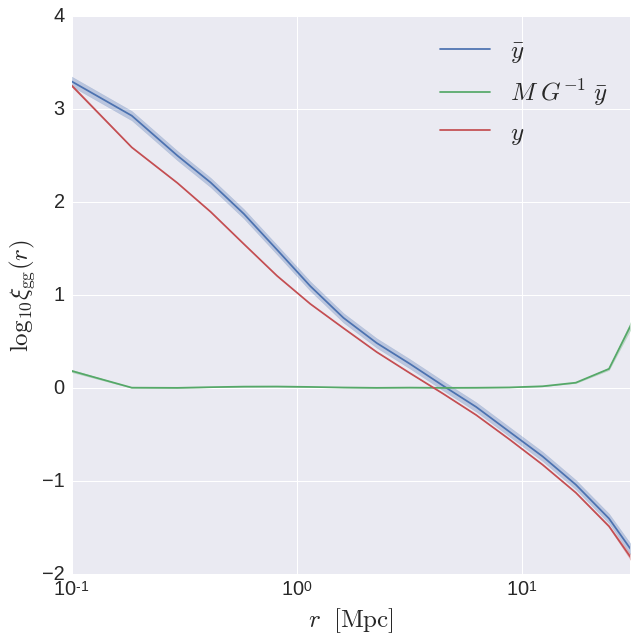

In [25]:
fig = plt.figure(figsize = (10, 10))

for mu, cov, label, color in zip([y_bar, np.abs(d), y], [G,D, T], [r'$ \bar{y} $',r'$M\;G^{-1}\;\bar{y}$', r'$y$'], colors):
    plt.plot(rpoints, mu, color=color, label=label)
    y_err = np.sqrt(np.diag(cov))
    plt.fill_between(rpoints,mu+y_err,
                mu-y_err, color = color, alpha = 0.3)

plt.xlim(xmin = 0.1, xmax = 30)
plt.ylim(ymin = -2, ymax = 4)
#plt.ylim(ymin = 1e-2, ymax = 1e4)
#plt.title("OR Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

plt.show()

In [14]:
import colormaps as cmaps
plt.register_cmap(name='viridis', cmap=cmaps.viridis)
plt.set_cmap(cmaps.viridis)

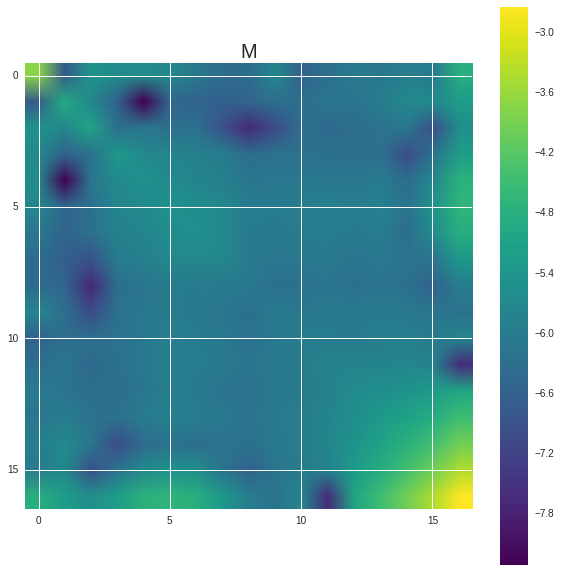

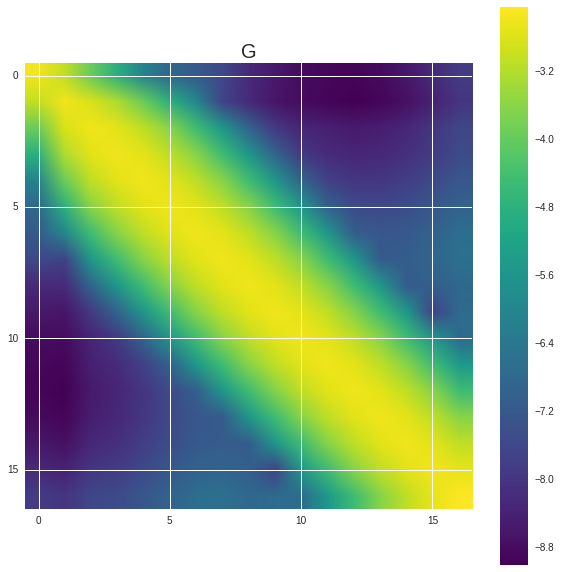

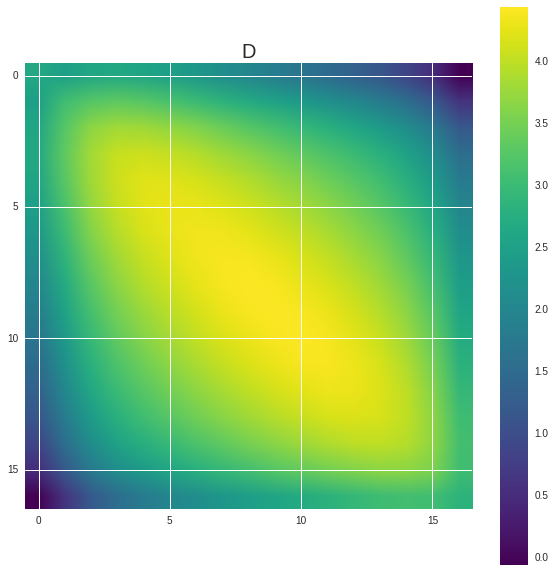

In [23]:
for label, mat in zip(['M', 'G','D'],(np.log10(np.abs(T)), np.log10(np.abs(G)),np.log10(np.abs(inv(G))), np.log10(np.abs(D))) ):
    fig = plt.figure(figsize=(10,10))
    plt.title(label, fontsize = 20)
    im = plt.imshow(mat, interpolation=None)
    plt.colorbar(im)
    plt.show()

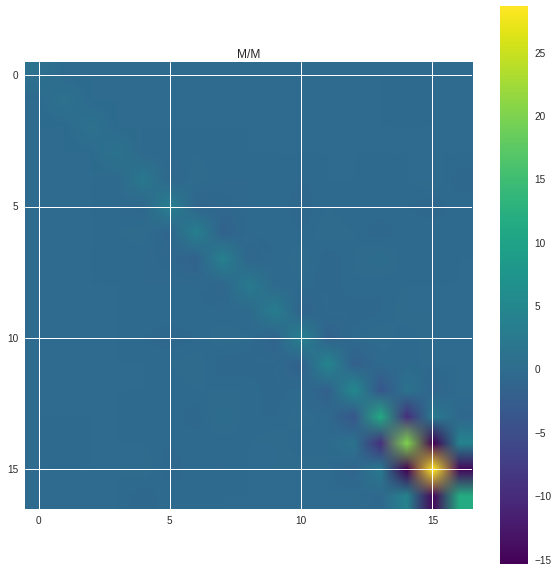

In [28]:
fig = plt.figure(figsize=(10,10))
plt.title('M/M', fontsize = 20)
im = plt.imshow(T*inv(T), interpolation=None)
plt.colorbar(im)
plt.show()

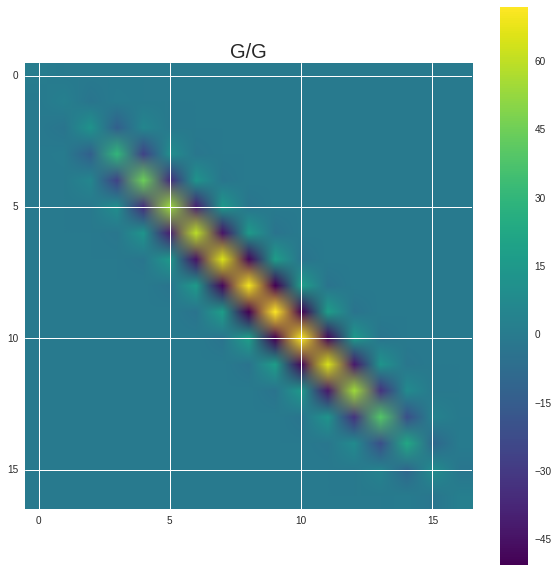

In [29]:
fig = plt.figure(figsize=(10,10))
plt.title('G/G', fontsize = 20)
im = plt.imshow(G*inv(G), interpolation=None)
plt.colorbar(im)
plt.show()

In [18]:
from scipy.linalg import eigh
print sorted(eigh(T, eigvals_only = True), reverse=True)
print np.sum(eigh(T, eigvals_only = True)>1e-3)

[0.0019103455546057458, 0.00019857980260920598, 3.2175544915131311e-05, 1.3539974790124528e-05, 1.170913277445411e-05, 7.5954468492852436e-06, 4.4983220018630828e-06, 2.175883746652214e-06, 1.5228437244444141e-06, 1.3405391945283978e-06, 7.0650998565423834e-07, 6.0120579798120299e-07, 4.4193510981240904e-07, 3.133279476803884e-07, 2.8005325248226892e-07, 2.2318670498978472e-07, 1.7934798668394448e-07]
1


In [19]:
print sorted(eigh(G, eigvals_only = True), reverse=True)
print np.sum(eigh(G, eigvals_only = True)>1e-3)

[0.0085926182266292707, 0.0078812923138363803, 0.0068272899187358689, 0.005611351788031421, 0.0044328003345127619, 0.0034965434670206344, 0.0027989738877433551, 0.0021212379559222621, 0.0015103299884036974, 0.00099604970651147708, 0.00060321498781789316, 0.00033782485157984952, 0.00017570894033880357, 8.5148636287322275e-05, 3.8183302919892793e-05, 1.6698343134000771e-05, 6.8138764913438781e-06]
9


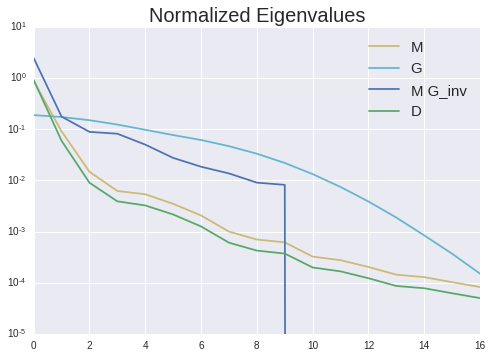

In [37]:
for mat, label,c in zip((T, G,np.dot(T, inv(G)), D), ['M', 'G','M G_inv', 'D'], colors):
    eigvals = sorted(eigh(mat,eigvals_only=True), reverse = True)
    norm_eigvals = eigvals/np.sum(eigvals)
    #print norm_eigvals
    plt.plot(norm_eigvals, label = label, color = c)
    
plt.title('Normalized Eigenvalues', fontsize = 20)
plt.yscale('log')
plt.legend(loc = 'best', fontsize = 15)
plt.show()